In [1]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
import IPython.display
import soundfile as sf
import os
import errno

In [2]:
# Need a function to remove dead space from audio files
# Checks a rolling average of signal over 1/10 sec and compares to threshold
# Returns a mask of True and False values that can be used to filter audio signals

def envelope(y, sr, threshold):
    r"""
    function to remove dead space from audio files
    """
    mask = []
    y_abs = pd.Series(y).apply(np.abs)
    y_mean = y_abs.rolling(window = int(sr/10), min_periods = 1, center = True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return np.array(y[mask])

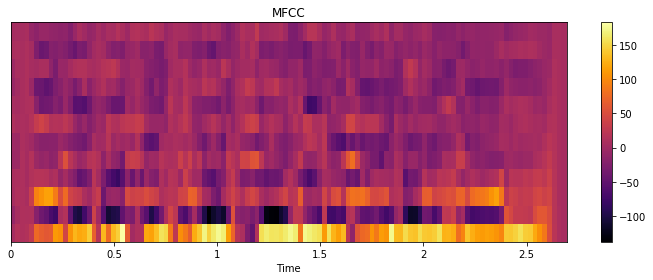

In [3]:
filename = 'datasets/kaymodb/angry/0_emodb_angry_113.wav'

y1, sr = librosa.load(filename)

y1 = envelope(y1, sr, 0.0005)

mfcc1 = librosa.feature.mfcc(y1, sr, n_mfcc = 26, n_fft = 552, hop_length = 552)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc1[1:13], x_axis='time', cmap = 'inferno')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show();

In [4]:
y1.shape[0]/sr

2.8858503401360545

In [5]:
mfcc1.shape[1] * 1/40

2.9

In [6]:
IPython.display.Audio(y1, rate=sr)

Tempo: 151.99908088235293BPM


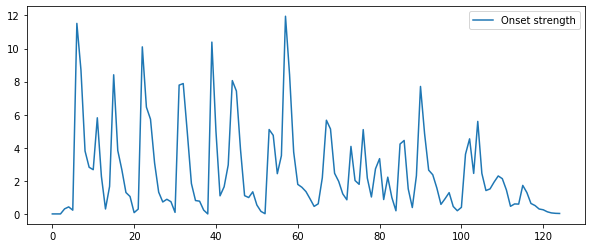

In [7]:
# Compute local onset autocorrelation
oenv1 = librosa.onset.onset_strength(y=y1, sr=sr)

# Estimate the global tempo for display purposes
tempo1 = librosa.beat.tempo(onset_envelope=oenv1, sr=sr)[0]

print("Tempo: " + str(tempo1) + "BPM")

plt.figure(figsize=(10, 4))
plt.plot(oenv1, label='Onset strength')
plt.legend(frameon=True)
plt.axis('tight');

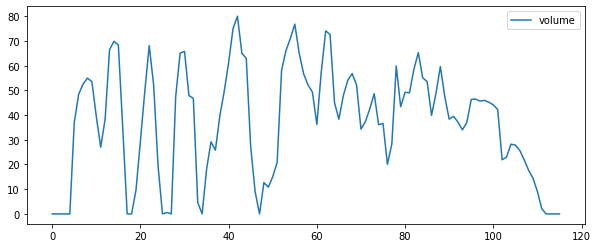

In [8]:
# Determine volume per frame
# Volume is a rather tricky metric due to how humans perceive sound
# This code computes the power spectrogram, sums the power components, then converts the power to db scale
# This should be a fairly realistic representation version of volume

S = librosa.stft(y1, n_fft = 552, hop_length = 552)**2
power = np.abs(S)**2
p_sum = np.sum(power, axis=0, keepdims=True)
loudness1 = librosa.power_to_db(p_sum)
n_frames1 = loudness1.shape[1]

loudness1 = loudness1 - loudness1.min()

plt.figure(figsize=(10, 4))
sns.lineplot(range(n_frames1), loudness1.reshape(n_frames1,), label = 'volume')
plt.legend(frameon=True)
plt.axis('tight');

### Preprocess

In [9]:
# Now write a script to pull out audio files, clean them, then save them to clean

import glob

kaymo_file_list = glob.glob('datasets/kaymodb/*/*.wav')

In [10]:
len(kaymo_file_list)

6267

In [11]:
from tqdm import tqdm

def clean_files(file_list):

    count = 0
    srs = set()

    for file in tqdm(file_list):
        y, sr = librosa.load(file)
#         srs.add(sr)
        y = envelope(y, sr, 0.0005)
        save_file = 'datasets/kaymodb_preprocessed/' + file
        
        if not os.path.exists(os.path.dirname(save_file)):
            try:
                os.makedirs(os.path.dirname(save_file))
            except OSError as exc: # Guard against race condition
                if exc.errno != errno.EEXIST:
                    raise
        
        with open(save_file, 'w') as new_file:
            sf.write(save_file, y, sr)
            new_file.close()
            
        count += 1
        if count % 1000 == 0:
            print(f'{count}: cleaned and saved 1000 files')
#             print('Sample Rates: ', srs)
    
    print("cleaning complete!")

In [12]:
clean_files(kaymo_file_list)

 16%|█▌        | 1001/6267 [02:55<12:00,  7.31it/s]

1000: cleaned and saved 100 files
Sample Rates:  {22050}


 32%|███▏      | 2000/6267 [05:33<10:55,  6.51it/s]

2000: cleaned and saved 100 files
Sample Rates:  {22050}


 48%|████▊     | 3001/6267 [08:18<07:58,  6.83it/s]

3000: cleaned and saved 100 files
Sample Rates:  {22050}


 64%|██████▍   | 4000/6267 [10:55<05:14,  7.20it/s]

4000: cleaned and saved 100 files
Sample Rates:  {22050}


 80%|███████▉  | 5000/6267 [14:01<02:53,  7.31it/s]

5000: cleaned and saved 100 files
Sample Rates:  {22050}


 96%|█████████▌| 6000/6267 [16:39<00:34,  7.82it/s]

6000: cleaned and saved 100 files
Sample Rates:  {22050}


100%|██████████| 6267/6267 [17:21<00:00,  5.41it/s]

cleaning complete!
